Notebook based on _Hands-On Graph Neural Networks Using Python_, by Maxime Labonne.

# Ch 4. Improving Embeddings with Biased Random Walks in Node2Vec

Similar to DeepWalk + Word2Vec for generating node embeddings, but improves upon them by modifying the approach to generating the random walks on graphs. The modified approach allows us to bias the random walks.

There is an actual Node2Vec library available, but in this chapter we aren't using it. Instead we implement Node2Vec ourselves so we can better understand how it works. In following chapters we'll use the Node2Vec library itself.

In [1]:
import random

from gensim.models.word2vec import Word2Vec
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
random.seed(0)
np.random.seed(0)

## 4.1 Generate biased random walks on a demo graph

In [3]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

In [4]:
# Node2Vec introduces p, q as bias params
def random_walk(start, length, p, q):
    walk = [start]
    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)
    return [str(x) for x in walk]


def next_node(previous, current, p, q):
    neighbors = list(G.neighbors(current))
    alphas = []
    for neighbor in neighbors:
        if neighbor == previous:
            alpha = 1.0 / p
        elif G.has_edge(neighbor, previous):
            alpha = 1.0
        else:
            alpha = 1.0 / q
        alphas.append(alpha)
    probs = [alpha / sum(alphas) for alpha in alphas]
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [5]:
# p=1, q=1 emulates DeepWalk
random_walk(0, 8, p=1, q=1)

['0', '4', '7', '6', '4', '5', '4', '5', '6']

In [6]:
# Bias
random_walk(0, 8, p=1, q=10)

['0', '9', '1', '9', '1', '9', '1', '0', '1']

## 4.2 Generate node embeddings for ZKC graph using Node2Vec

ZKC = Zachary's Karate Club

### 4.2.1 Get ZKC graph

In [7]:
G = nx.karate_club_graph()

In [8]:
# Extract labels for plotting
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

In [9]:
def plot_graph(graph, labels):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    nx.draw_networkx(
        graph,
        pos=nx.spring_layout(graph, seed=0),
        node_color=labels,
        node_size=800,
        cmap='coolwarm',
        font_size=14,
        font_color='white'
    )

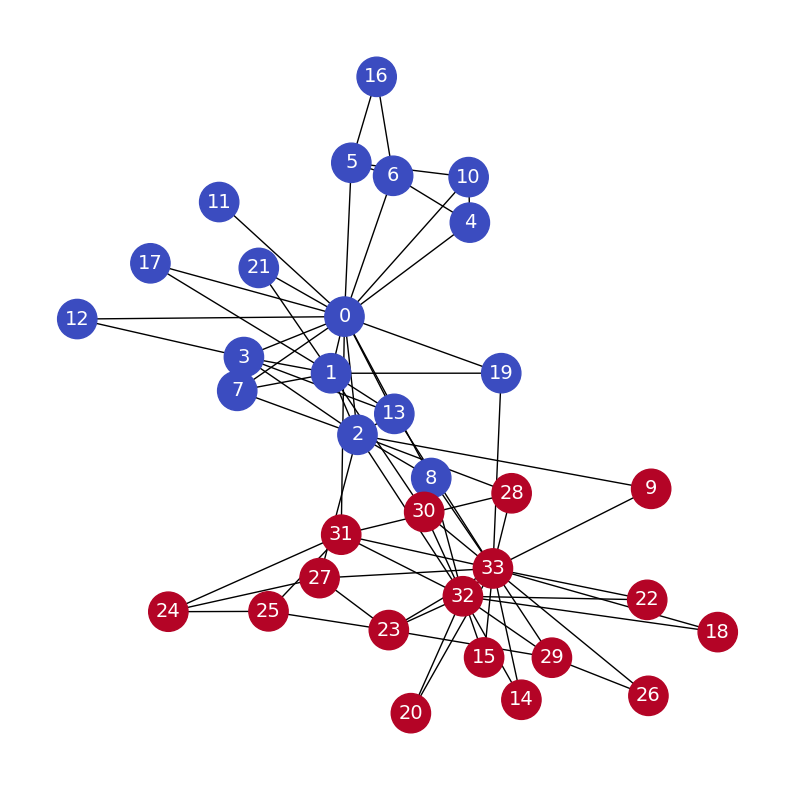

In [10]:
plot_graph(G, labels)

### 4.2.2 Generate biased random walks on ZKC graph

In [11]:
def generate_random_walks(graph, p, q):
    walks = []
    for node in graph.nodes:
        # Generate 80 random walks for each node
        for _ in range(80):
            walks.append(random_walk(node, 10, p, q))
    return walks

In [12]:
walks = generate_random_walks(G, p=3, q=2)

In [13]:
walks[0:2]

[['0', '1', '21', '1', '21', '1', '19', '0', '17', '0', '11'],
 ['0', '3', '13', '2', '3', '1', '19', '0', '10', '0', '11']]

### 4.2.3 Train Word2Vec on the biased random walks

This maps walks to embeddings.

In [14]:
node2vec = Word2Vec(
    walks,
    hs=1,  # hierarchical softmax
    sg=1,  # 0=CBOW, 1=skip-gram
    vector_size=100,
    window=10,
    workers=2,
    min_count=1,
    seed=0
)

In [15]:
node2vec.train(
    walks,
    total_examples=node2vec.corpus_count,
    epochs=30,
    report_delay=1
)

(185668, 897600)

In [16]:
# Example of post-training usage
# This shows the "word vector" (embedding) for "word" (node) "12"
node2vec.wv['12']

array([-0.01764557,  0.06169991,  0.00869858, -0.116174  ,  0.03724476,
        0.1866904 , -0.11850453,  0.07957803,  0.19209746,  0.07683654,
       -0.29569373, -0.2198205 , -0.2108975 ,  0.04578013,  0.27996993,
        0.06473915,  0.07379541, -0.13376519, -0.17348586, -0.06284101,
       -0.06648123, -0.00769439,  0.10200071,  0.08787433,  0.17840259,
       -0.13902366, -0.18145894,  0.10878045, -0.02779353, -0.325152  ,
        0.15409893, -0.12776695,  0.3073713 ,  0.0761509 , -0.07573328,
       -0.06893407,  0.11459451,  0.04857454, -0.12918468,  0.00929499,
       -0.02196199,  0.28821927,  0.01220842,  0.07504613,  0.14647381,
       -0.14878649, -0.13928354,  0.10421403,  0.04932034,  0.22493038,
       -0.12900932,  0.22250712, -0.22307171, -0.08337165, -0.33978146,
       -0.06225725,  0.09141016,  0.54162776, -0.00612974,  0.12265301,
        0.11468118,  0.03534885,  0.04457514,  0.05230103, -0.3068037 ,
       -0.05195162, -0.04096701, -0.26224563, -0.08273624, -0.16

In [17]:
node2vec.wv['33']

array([ 0.17050102, -0.16569103, -0.06244706, -0.19128977, -0.03134393,
       -0.24611352, -0.2990811 , -0.28417146, -0.02658768,  0.12406579,
        0.30435002,  0.14923798,  0.18324615,  0.1975296 ,  0.17240755,
       -0.1391924 ,  0.02436911, -0.14850545,  0.01609409, -0.09564631,
       -0.06041138,  0.09423126,  0.18770246, -0.21729158,  0.20229286,
        0.12266649,  0.03236074, -0.16204964,  0.12953104,  0.03778092,
        0.03692693, -0.1413391 ,  0.16399227,  0.1064128 , -0.32967687,
        0.04601156,  0.05600255,  0.15374473, -0.09605329, -0.03428354,
        0.04684539, -0.11444282, -0.23482773, -0.00857401,  0.00482352,
       -0.08232967, -0.15434018, -0.13525675, -0.12446374,  0.22088468,
       -0.01590281, -0.00605543, -0.04175646,  0.24234381,  0.1715999 ,
        0.12437063, -0.09155802,  0.12129837,  0.2110681 ,  0.17316595,
        0.21611336,  0.10909228,  0.12457704, -0.15932249,  0.20536377,
       -0.14248736, -0.14187756,  0.08654824,  0.06217977,  0.05

## 4.3 Application: Train random forest classifier on ZKC embeddings

In [18]:
def get_embeddings_and_labels(model, labels, mask):
    mask_str = [str(x) for x in mask]
    return model.wv[mask_str], labels[mask]

In [19]:
labels_arr = np.array(labels)

train_mask = list(range(2, 26, 2))
train_embs, train_labels = get_embeddings_and_labels(node2vec, labels_arr, train_mask)

test_mask = [0] + list(range(1, 27, 2)) + list(range(26, 34))
test_embs, test_labels = get_embeddings_and_labels(node2vec, labels_arr, test_mask)

In [20]:
clf = RandomForestClassifier(random_state=0)
clf.fit(train_embs, train_labels)

RandomForestClassifier(random_state=0)

In [21]:
# Evaluate classifier
y_pred = clf.predict(test_embs)
acc = accuracy_score(y_pred, test_labels)
print(f'node2vec accuracy = {acc*100.0:.2f}%')

node2vec accuracy = 100.00%


In [22]:
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [23]:
test_labels

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## 4.4 Grid search p, q based on ZKC classifier performance

This is a search for the best choices for random walk params p, q, based on classifier performance. This shows how to test the embeddings in an end-to-end fashion. That is, here we judge the embeddings based on the performance of the associated classifiers. (Note: It's the testing that's end-to-end. The training happens independently of the classifier application.)

In [24]:
def do_grid_search(graph, p_range, q_range, n, labels, train_mask, test_mask):
    result = {}
    p_min, p_max = p_range
    q_min, q_max = q_range
    for p in range(p_min, p_max):
        for q in range(q_min, q_max):
            mean, std = evaluate_params(graph, p, q, n, labels, train_mask, test_mask)
            print(f'p={p}, q={q}: mean={mean}, std={std}')
            result[(p, q)] = (mean, std)
    return result


def evaluate_params(graph, p, q, n, labels, train_mask, test_mask):
    scores = []
    for i in range(n):
        walks = generate_random_walks(graph, p, q)
        node2vec = Word2Vec(walks, hs=1, sg=1, vector_size=100, window=10, workers=2, min_count=1)
        node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

        train_embs, train_labels = get_embeddings_and_labels(node2vec, labels, train_mask)
        test_embs, test_labels = get_embeddings_and_labels(node2vec, labels, test_mask)
        clf = RandomForestClassifier()
        clf.fit(train_embs, train_labels)
        
        y_pred = clf.predict(test_embs)
        scores.append(accuracy_score(y_pred, test_labels))
        
    return np.mean(scores), np.std(scores)

In [25]:
p_range = (1, 8)
q_range = (1, 8)

In [26]:
scores = do_grid_search(G, p_range, q_range, 20, labels_arr, train_mask, test_mask)

p=1, q=1: mean=0.9363636363636365, std=0.044069816885603005
p=1, q=2: mean=0.9113636363636364, std=0.04424527803166315
p=1, q=3: mean=0.8999999999999998, std=0.042152811343162296
p=1, q=4: mean=0.9068181818181816, std=0.050768881599292444
p=1, q=5: mean=0.925, std=0.048265364958171145
p=1, q=6: mean=0.934090909090909, std=0.048691557467337616
p=1, q=7: mean=0.9204545454545453, std=0.047401485487759576
p=2, q=1: mean=0.9181818181818182, std=0.04679831882266819
p=2, q=2: mean=0.9386363636363635, std=0.03876982297552724
p=2, q=3: mean=0.9295454545454545, std=0.058343171149970154
p=2, q=4: mean=0.925, std=0.05974290649134053
p=2, q=5: mean=0.9113636363636364, std=0.050768881599292444
p=2, q=6: mean=0.9295454545454547, std=0.03929912833134225
p=2, q=7: mean=0.9045454545454543, std=0.03491429885394823
p=3, q=1: mean=0.9204545454545455, std=0.04740148548775957
p=3, q=2: mean=0.9363636363636362, std=0.03910147848655741
p=3, q=3: mean=0.925, std=0.04134864863331876
p=3, q=4: mean=0.943181818181

In [27]:
def display_scores(scores, p_range, q_range):
    p_min, p_max = p_range
    q_min, q_max = q_range
    html = "<table><tr><td></td>"
    for j in range(q_min, q_max):
        html += f"<td>p={j}</td>"
    html += "</tr>"
    for i in range(p_min, p_max):
        html += f"<tr><td>q={i}</td>"
        for j in range(q_min, q_max):
            score = scores[(i, j)]
            mean = f"{(score[0] * 100):.2f}%"
            std = f"(&plusmn;{(score[1] * 100):.2f}%)"
            html += f"<td>{mean}<br>{std}</td>"
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

In [28]:
display_scores(scores, p_range, q_range)

,p=1,p=2,p=3,p=4,p=5,p=6,p=7
q=1,93.64%(±4.41%),91.14%(±4.42%),90.00%(±4.22%),90.68%(±5.08%),92.50%(±4.83%),93.41%(±4.87%),92.05%(±4.74%)
q=2,91.82%(±4.68%),93.86%(±3.88%),92.95%(±5.83%),92.50%(±5.97%),91.14%(±5.08%),92.95%(±3.93%),90.45%(±3.49%)
q=3,92.05%(±4.74%),93.64%(±3.91%),92.50%(±4.13%),94.32%(±4.28%),94.77%(±3.60%),92.05%(±4.03%),93.64%(±4.17%)
q=4,91.59%(±5.04%),94.32%(±4.74%),93.41%(±3.04%),92.95%(±4.65%),92.27%(±3.83%),93.41%(±4.42%),92.95%(±3.66%)
q=5,94.55%(±4.68%),95.23%(±3.66%),94.32%(±4.03%),93.64%(±5.45%),92.27%(±5.00%),93.86%(±2.97%),92.27%(±3.55%)
q=6,92.50%(±5.97%),95.00%(±3.78%),95.45%(±4.55%),94.77%(±4.13%),92.05%(±4.95%),95.68%(±3.93%),94.09%(±4.09%)
q=7,91.82%(±6.03%),95.23%(±4.18%),92.95%(±4.18%),94.77%(±3.60%),94.55%(±4.45%),96.82%(±2.91%),94.77%(±5.80%)
